In [88]:
import pandas as pd
import geopandas as gpd

# Load your data into a GeoDataFrame (if not already)
traffic_data = gpd.read_file('wellington_crash.geojson')  # Example

# Ensure your GeoDataFrame has a geometry column
traffic_data = traffic_data.set_geometry('geometry')

# Assuming 'location_id' is the column that identifies the location of each crash
# If each row is a crash, you can just use the index or a unique identifier

# Group by location and count the crashes
crash_counts = (traffic_data
                .groupby('areaUnitID')  # Replace 'location_id' with your relevant column
                .size()  # Counts the number of rows per group
                .reset_index(name='crash_count'))  # Create a DataFrame with counts

# Merge the crash counts back to the original GeoDataFrame
traffic_data = traffic_data.merge(crash_counts, on='areaUnitID', how='left')

# Now, traffic_data should have a new column 'crash_count'


In [89]:
traffic_data.columns

Index(['OBJECTID', 'advisorySpeed', 'areaUnitID', 'bicycle', 'bridge', 'bus',
       'carStationWagon', 'cliffBank', 'crashDirectionDescription',
       'crashFinancialYear', 'crashLocation1', 'crashLocation2',
       'crashRoadSideRoad', 'crashSeverity', 'crashSHDescription', 'crashYear',
       'debris', 'directionRoleDescription', 'ditch', 'fatalCount', 'fence',
       'flatHill', 'guardRail', 'holiday', 'houseOrBuilding', 'intersection',
       'kerb', 'light', 'meshblockId', 'minorInjuryCount', 'moped',
       'motorcycle', 'NumberOfLanes', 'objectThrownOrDropped', 'otherObject',
       'otherVehicleType', 'overBank', 'parkedVehicle', 'pedestrian',
       'phoneBoxEtc', 'postOrPole', 'region', 'roadCharacter', 'roadLane',
       'roadSurface', 'roadworks', 'schoolBus', 'seriousInjuryCount',
       'slipOrFlood', 'speedLimit', 'strayAnimal', 'streetLight', 'suv',
       'taxi', 'temporarySpeedLimit', 'tlaId', 'tlaName', 'trafficControl',
       'trafficIsland', 'trafficSign', 'trai

In [90]:
traffic_data.head()

,OBJECTID,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,crashDirectionDescription,crashFinancialYear,...,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB,geometry,crash_count
0,66388986,NaN,575300,0.0,0.0,0.0,1.0,1.0,South,2018/2019,...,0.0,0.0,Urban,0.0,0.0,0.0,Light rain,Null,POINT (174.7576 -41.28854),188
1,66388998,NaN,572600,0.0,0.0,0.0,2.0,0.0,North,2017/2018,...,0.0,0.0,Urban,0.0,0.0,0.0,Fine,Null,POINT (174.82511 -41.16802),165
2,66389034,NaN,577000,0.0,NaN,0.0,1.0,NaN,South,2019/2020,...,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null,POINT (174.81144 -41.3266),175
3,66389036,NaN,576800,0.0,NaN,0.0,0.0,NaN,East,2018/2019,...,0.0,0.0,Urban,1.0,NaN,NaN,Light rain,Null,POINT (174.79145 -41.30418),199
4,66389128,NaN,572900,0.0,NaN,0.0,2.0,NaN,Null,2017/2018,...,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null,POINT (174.77253 -41.27599),905


Global Moran's I: 0.9671465191696389
Expected Moran's I: -8.136696501220504e-05
Z-score: 193.6780948960664
P-value: 0.0


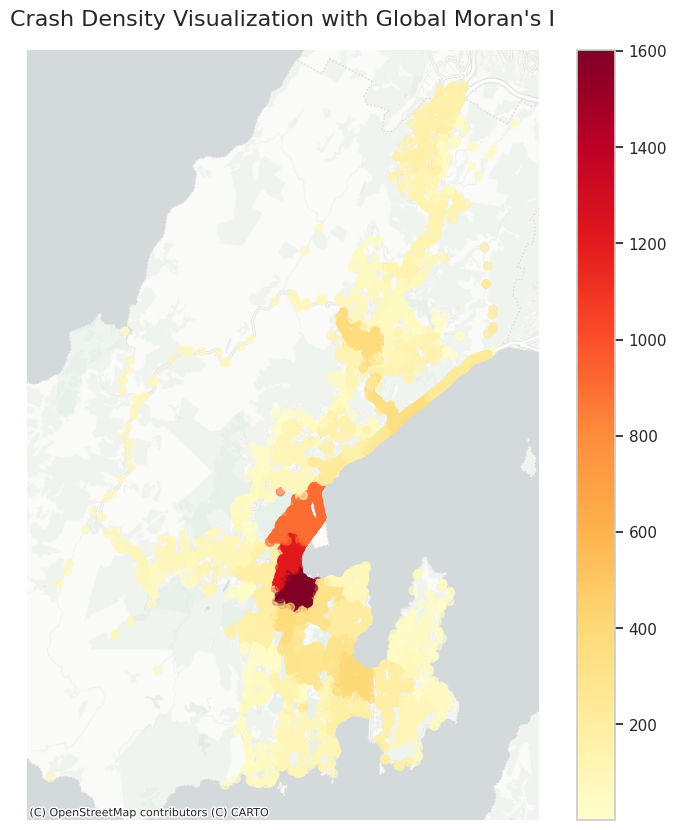

In [91]:
import geopandas as gpd
import matplotlib.pyplot as plt
from esda import Moran
from libpysal import weights
import contextily as ctx

# Ensure the traffic data is in EPSG:3857
traffic_data = traffic_data.to_crs(epsg=3857)

# Create a spatial weights matrix
w = weights.Queen.from_dataframe(traffic_data, use_index=True)

# Calculate Global Moran's I using the Moran class
moran_global = Moran(traffic_data['crash_count'], w)

# Output Global Moran's I statistics
print(f"Global Moran's I: {moran_global.I}")
print(f"Expected Moran's I: {moran_global.EI}")
print(f"Z-score: {moran_global.z_norm}")
print(f"P-value: {moran_global.p_norm}")

# Add the global Moran's I results to the GeoDataFrame if needed
traffic_data['global_moran'] = moran_global.I

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with the original crash counts
traffic_data.plot(ax=ax, column='crash_count', cmap='YlOrRd', legend=True, alpha=0.6)

# Add the basemap
ctx.add_basemap(
    ax,
    crs=traffic_data.crs.to_string(),
    source=ctx.providers.CartoDB.PositronNoLabels
)

# Remove axes for better visualization
ax.set_axis_off()

# Add a title
plt.title("Crash Density Visualization with Global Moran's I", fontsize=16)

plt.show()


Remaining rows after cleaning: 8124


/opt/miniconda/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 11 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Moran's I for Non-Injury Crash Counts: 0.9708609787816478
p-value: 0.001


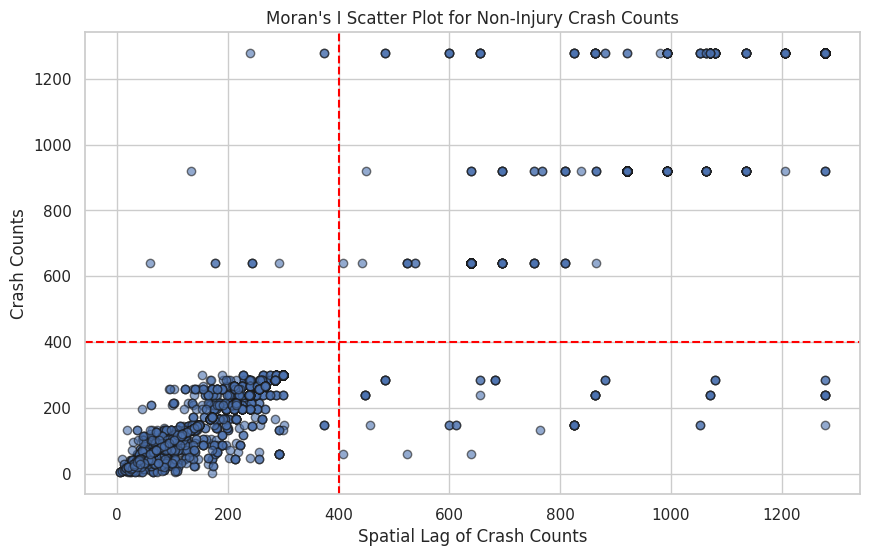

In [92]:
import geopandas as gpd
import libpysal
from esda import Moran
import matplotlib.pyplot as plt

# Load your data
try:
    traffic_data = gpd.read_file('wellington_crash.geojson')
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Filter the data for Non-Injury Crashes
non_injury_data = traffic_data[traffic_data['crashSeverity'] == 'Non-Injury Crash']

# Group by area unit and count the non-injury crashes
crash_counts = (non_injury_data
                .groupby('areaUnitID')  # Replace 'areaUnitID' with your relevant column if needed
                .size()  # Counts the number of rows per group
                .reset_index(name='crash_count'))  # Create a DataFrame with counts

# Merge crash counts back to the original GeoDataFrame to retain geometry
crash_counts_geo_non_injury = non_injury_data[['areaUnitID', 'geometry']].drop_duplicates()
crash_counts_geo_non_injury = crash_counts_geo_non_injury.merge(crash_counts, on='areaUnitID')

# Clean your data: drop rows with NaN values in the crash count column
crash_counts_geo_non_injury = crash_counts_geo_non_injury.dropna(subset=['crash_count'])

# Check if there are any remaining rows after cleaning
print(f"Remaining rows after cleaning: {len(crash_counts_geo_non_injury)}")

# Create a spatial weights matrix (e.g., k-nearest neighbors)
w = libpysal.weights.KNN.from_dataframe(crash_counts_geo_non_injury, k=5)

# Calculate Moran's I for crash counts
moran_crash = Moran(crash_counts_geo['crash_count'], w)

# Output results
print("Moran's I for Non-Injury Crash Counts:", moran_crash.I)
print("p-value:", moran_crash.p_sim)

# Create Moran's I scatter plot
lag_crash_counts = libpysal.weights.lag_spatial(w, crash_counts_geo_non_injury['crash_count'])

plt.figure(figsize=(10, 6))
plt.scatter(lag_crash_counts, crash_counts_geo_non_injury['crash_count'], alpha=0.6, edgecolor='k')
plt.xlabel('Spatial Lag of Crash Counts')
plt.ylabel('Crash Counts')
plt.title("Moran's I Scatter Plot for Non-Injury Crash Counts")
plt.axhline(y=crash_counts_geo_non_injury['crash_count'].mean(), color='red', linestyle='--')
plt.axvline(x=lag_crash_counts.mean(), color='red', linestyle='--')
plt.grid(True)
plt.show()


In [100]:
print(crash_counts_geo_non_injury[['local_moran', 'z_sim', 'significance']].head())


   local_moran     z_sim  significance
0     0.392554  1.728333         0.026
1     0.450661  1.298542         0.074
2     0.377929  1.364162         0.086
3     0.317476  1.260439         0.112
4     0.650266  0.647269         0.245


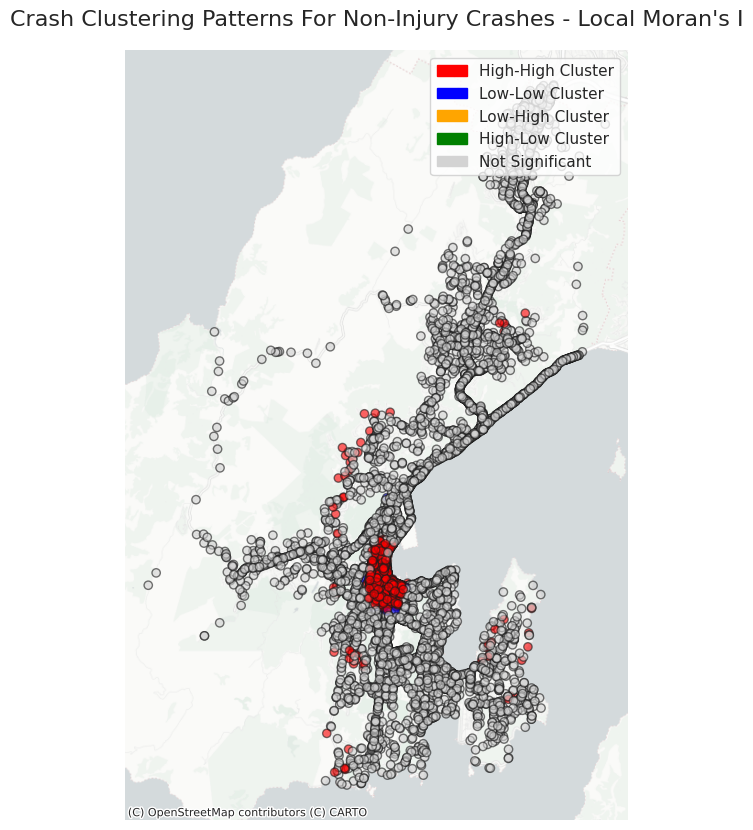

In [93]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from esda import Moran_Local
from libpysal import weights
import contextily as ctx

# Filter the data for Non-Injury Crashes
non_injury_data = traffic_data[traffic_data['crashSeverity'] == 'Non-Injury Crash']

# Group by area unit and count the Non-Injury crashes
crash_counts_non_injury = (non_injury_data
                            .groupby('areaUnitID')  # Adjust as necessary
                            .size()
                            .reset_index(name='crash_count'))  # Create a DataFrame with counts

# Merge crash counts back to the original GeoDataFrame to retain geometry
crash_counts_geo_non_injury = non_injury_data[['areaUnitID', 'geometry']].drop_duplicates()
crash_counts_geo_non_injury = crash_counts_geo_non_injury.merge(crash_counts_non_injury, on='areaUnitID', how='left')

# Clean your data: drop rows with NaN values in the crash count column
crash_counts_geo_non_injury = crash_counts_geo_non_injury.dropna(subset=['crash_count'])

# Ensure the crash_counts_geo_non_injury data is in EPSG:3857
crash_counts_geo_non_injury = crash_counts_geo_non_injury.to_crs(epsg=3857)

# Create a spatial weights matrix
w_non_injury = weights.Queen.from_dataframe(crash_counts_geo_non_injury, use_index=True)

# Calculate Local Moran's I using the Moran_Local class
moran_local_non_injury = Moran_Local(crash_counts_geo_non_injury['crash_count'], w_non_injury)

# Add Local Moran's I results to the GeoDataFrame
crash_counts_geo_non_injury['local_moran'] = moran_local_non_injury.Is  # Local Moran's I values
crash_counts_geo_non_injury['significance'] = moran_local_non_injury.p_sim  # p-value for significance
crash_counts_geo_non_injury['z_sim'] = moran_local_non_injury.z_sim  # Standardized statistic

# Define custom thresholds based on percentiles for more balanced clusters
high_threshold_moran_non_injury = crash_counts_geo_non_injury['local_moran'].quantile(0.75)  # 75th percentile
low_threshold_moran_non_injury = crash_counts_geo_non_injury['local_moran'].quantile(0.25)   # 25th percentile

high_threshold_z_non_injury = crash_counts_geo_non_injury['z_sim'].quantile(0.75)  # 75th percentile
low_threshold_z_non_injury = crash_counts_geo_non_injury['z_sim'].quantile(0.25)   # 25th percentile

# Use a higher significance threshold to capture more clusters
significance_threshold_non_injury = 0.05

# Define conditions for each cluster type
conditions_non_injury = [
    (crash_counts_geo_non_injury['significance'] < significance_threshold_non_injury) & 
    (crash_counts_geo_non_injury['local_moran'] > high_threshold_moran_non_injury) & 
    (crash_counts_geo_non_injury['z_sim'] > high_threshold_z_non_injury),  # high-high
    
    (crash_counts_geo_non_injury['significance'] < significance_threshold_non_injury) & 
    (crash_counts_geo_non_injury['local_moran'] < low_threshold_moran_non_injury) & 
    (crash_counts_geo_non_injury['z_sim'] < low_threshold_z_non_injury),  # low-low
    
    (crash_counts_geo_non_injury['significance'] < significance_threshold_non_injury) & 
    (crash_counts_geo_non_injury['local_moran'] < low_threshold_moran_non_injury) & 
    (crash_counts_geo_non_injury['z_sim'] > high_threshold_z_non_injury),  # low-high
    
    (crash_counts_geo_non_injury['significance'] < significance_threshold_non_injury) & 
    (crash_counts_geo_non_injury['local_moran'] > high_threshold_moran_non_injury) & 
    (crash_counts_geo_non_injury['z_sim'] < low_threshold_z_non_injury)   # high-low
]

# Define labels for clusters
cluster_labels_non_injury = ['high-high', 'low-low', 'low-high', 'high-low']

# Apply conditions to assign cluster types
crash_counts_geo_non_injury['cluster_type'] = np.select(conditions_non_injury, cluster_labels_non_injury, default='Not Significant')

# Define colors for each cluster type
color_mapping_non_injury = {
    'high-high': 'red',
    'low-low': 'blue',
    'low-high': 'orange',
    'high-low': 'green',
    'Not Significant': 'lightgrey'
}

# Apply color mapping
crash_counts_geo_non_injury['color'] = crash_counts_geo_non_injury['cluster_type'].map(color_mapping_non_injury)

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with colors
crash_counts_geo_non_injury.plot(ax=ax, color=crash_counts_geo_non_injury['color'], alpha=0.6, edgecolor='k')

# Add the basemap
ctx.add_basemap(
    ax,  # Pass the axis to the basemap
    crs=crash_counts_geo_non_injury.crs.to_string(),  # Use the crash_counts_geo_non_injury data's CRS
    source=ctx.providers.CartoDB.PositronNoLabels
)

# Remove axes for better visualization
ax.set_axis_off()

# Add a title
plt.title("Crash Clustering Patterns For Non-Injury Crashes - Local Moran's I", fontsize=16)

# Create a custom legend
import matplotlib.patches as mpatches

legend_elements_non_injury = [
    mpatches.Patch(color='red', label='High-High Cluster'),
    mpatches.Patch(color='blue', label='Low-Low Cluster'),
    mpatches.Patch(color='orange', label='Low-High Cluster'),
    mpatches.Patch(color='green', label='High-Low Cluster'),
    mpatches.Patch(color='lightgrey', label='Not Significant')
]

ax.legend(handles=legend_elements_non_injury, loc='upper right')

# Show the plot
plt.show()


Remaining rows after cleaning: 2506


/opt/miniconda/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Moran's I for Minor Crash Counts: 0.9596029997524255
p-value: 0.001


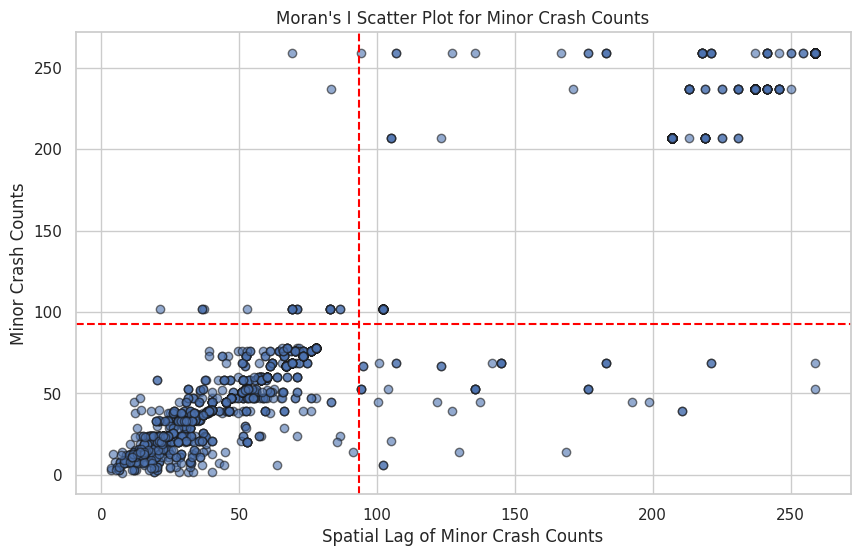

In [94]:
import geopandas as gpd
import libpysal
from esda import Moran
import matplotlib.pyplot as plt

# Load your data
try:
    traffic_data = gpd.read_file('wellington_crash.geojson')  # Replace with your file
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Filter the data for Minor Crashes
minor_data = traffic_data[traffic_data['crashSeverity'] == 'Minor Crash']

# Group by area unit and count the minor crashes
crash_counts_minor = (minor_data
                      .groupby('areaUnitID')  # Replace 'areaUnitID' with your relevant column if needed
                      .size()  # Counts the number of rows per group
                      .reset_index(name='crash_count'))  # Create a DataFrame with counts

# Merge crash counts back to the original GeoDataFrame to retain geometry
crash_counts_geo_minor = minor_data[['areaUnitID', 'geometry']].drop_duplicates()
crash_counts_geo_minor = crash_counts_geo_minor.merge(crash_counts_minor, on='areaUnitID')

# Clean your data: drop rows with NaN values in the crash count column
crash_counts_geo_minor = crash_counts_geo_minor.dropna(subset=['crash_count'])

# Check if there are any remaining rows after cleaning
print(f"Remaining rows after cleaning: {len(crash_counts_geo_minor)}")

# Create a spatial weights matrix (e.g., k-nearest neighbors)
w_minor = libpysal.weights.KNN.from_dataframe(crash_counts_geo_minor, k=5)

# Calculate Moran's I for minor crash counts
moran_crash_minor = Moran(crash_counts_geo_minor['crash_count'], w_minor)

# Output results
print("Moran's I for Minor Crash Counts:", moran_crash_minor.I)
print("p-value:", moran_crash_minor.p_sim)

# Create Moran's I scatter plot
lag_crash_counts_minor = libpysal.weights.lag_spatial(w_minor, crash_counts_geo_minor['crash_count'])

plt.figure(figsize=(10, 6))
plt.scatter(lag_crash_counts_minor, crash_counts_geo_minor['crash_count'], alpha=0.6, edgecolor='k')
plt.xlabel('Spatial Lag of Minor Crash Counts')
plt.ylabel('Minor Crash Counts')
plt.title("Moran's I Scatter Plot for Minor Crash Counts")
plt.axhline(y=crash_counts_geo_minor['crash_count'].mean(), color='red', linestyle='--')
plt.axvline(x=lag_crash_counts_minor.mean(), color='red', linestyle='--')
plt.grid(True)
plt.show()


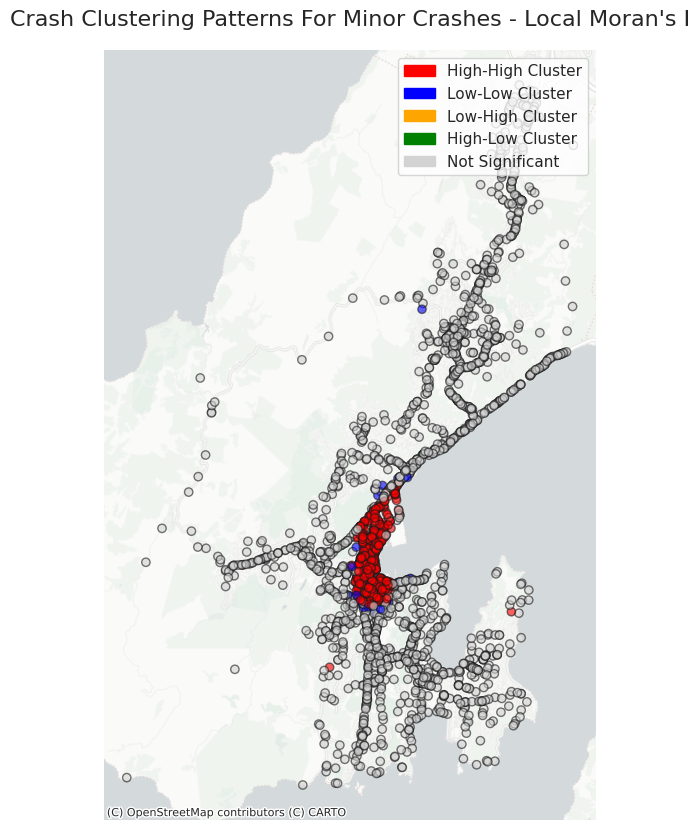

In [95]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from esda import Moran_Local
from libpysal import weights
import contextily as ctx

# Filter the data for Minor Crashes
minor_data = traffic_data[traffic_data['crashSeverity'] == 'Minor Crash']

# Group by area unit and count the minor crashes
crash_counts_minor = (minor_data
                      .groupby('areaUnitID')  # Adjust as necessary
                      .size()
                      .reset_index(name='crash_count'))  # Create a DataFrame with counts

# Merge crash counts back to the original GeoDataFrame to retain geometry
crash_counts_geo_minor = minor_data[['areaUnitID', 'geometry']].drop_duplicates()
crash_counts_geo_minor = crash_counts_geo_minor.merge(crash_counts_minor, on='areaUnitID', how='left')

# Clean your data: drop rows with NaN values in the crash count column
crash_counts_geo_minor = crash_counts_geo_minor.dropna(subset=['crash_count'])

# Ensure the crash_counts_geo_minor data is in EPSG:3857
crash_counts_geo_minor = crash_counts_geo_minor.to_crs(epsg=3857)

# Create a spatial weights matrix
w_minor = weights.Queen.from_dataframe(crash_counts_geo_minor, use_index=True)

# Calculate Local Moran's I using the Moran_Local class
moran_local_minor = Moran_Local(crash_counts_geo_minor['crash_count'], w_minor)

# Add Local Moran's I results to the GeoDataFrame
crash_counts_geo_minor['local_moran'] = moran_local_minor.Is  # Local Moran's I values
crash_counts_geo_minor['significance'] = moran_local_minor.p_sim  # p-value for significance
crash_counts_geo_minor['z_sim'] = moran_local_minor.z_sim  # Standardized statistic

# Define custom thresholds based on percentiles for more balanced clusters
high_threshold_moran_minor = crash_counts_geo_minor['local_moran'].quantile(0.75)  # 75th percentile
low_threshold_moran_minor = crash_counts_geo_minor['local_moran'].quantile(0.25)   # 25th percentile

high_threshold_z_minor = crash_counts_geo_minor['z_sim'].quantile(0.75)  # 75th percentile
low_threshold_z_minor = crash_counts_geo_minor['z_sim'].quantile(0.25)   # 25th percentile

# Use a higher significance threshold to capture more clusters
significance_threshold_minor = 0.05

# Define conditions for each cluster type
conditions_minor = [
    (crash_counts_geo_minor['significance'] < significance_threshold_minor) & 
    (crash_counts_geo_minor['local_moran'] > high_threshold_moran_minor) & 
    (crash_counts_geo_minor['z_sim'] > high_threshold_z_minor),  # high-high
    
    (crash_counts_geo_minor['significance'] < significance_threshold_minor) & 
    (crash_counts_geo_minor['local_moran'] < low_threshold_moran_minor) & 
    (crash_counts_geo_minor['z_sim'] < low_threshold_z_minor),  # low-low
    
    (crash_counts_geo_minor['significance'] < significance_threshold_minor) & 
    (crash_counts_geo_minor['local_moran'] < low_threshold_moran_minor) & 
    (crash_counts_geo_minor['z_sim'] > high_threshold_z_minor),  # low-high
    
    (crash_counts_geo_minor['significance'] < significance_threshold_minor) & 
    (crash_counts_geo_minor['local_moran'] > high_threshold_moran_minor) & 
    (crash_counts_geo_minor['z_sim'] < low_threshold_z_minor)   # high-low
]

# Define labels for clusters
cluster_labels_minor = ['high-high', 'low-low', 'low-high', 'high-low']

# Apply conditions to assign cluster types
crash_counts_geo_minor['cluster_type'] = np.select(conditions_minor, cluster_labels_minor, default='Not Significant')

# Define colors for each cluster type
color_mapping_minor = {
    'high-high': 'red',
    'low-low': 'blue',
    'low-high': 'orange',
    'high-low': 'green',
    'Not Significant': 'lightgrey'
}

# Apply color mapping
crash_counts_geo_minor['color'] = crash_counts_geo_minor['cluster_type'].map(color_mapping_minor)

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with colors
crash_counts_geo_minor.plot(ax=ax, color=crash_counts_geo_minor['color'], alpha=0.6, edgecolor='k')  # Added edgecolor for visibility

# Add the basemap
ctx.add_basemap(
    ax,  # Pass the axis to the basemap
    crs=crash_counts_geo_minor.crs.to_string(),  # Use the crash_counts_geo_minor data's CRS
    source=ctx.providers.CartoDB.PositronNoLabels
)

# Remove axes for better visualization
ax.set_axis_off()

# Add a title
plt.title("Crash Clustering Patterns For Minor Crashes - Local Moran's I", fontsize=16)

# Create a custom legend
import matplotlib.patches as mpatches

legend_elements_minor = [
    mpatches.Patch(color='red', label='High-High Cluster'),
    mpatches.Patch(color='blue', label='Low-Low Cluster'),
    mpatches.Patch(color='orange', label='Low-High Cluster'),
    mpatches.Patch(color='green', label='High-Low Cluster'),
    mpatches.Patch(color='lightgrey', label='Not Significant')
]

ax.legend(handles=legend_elements_minor, loc='upper right')

# Show the plot
plt.show()


In [96]:
import geopandas as gpd
import libpysal
from esda import Moran

# Filter the data for Fatal and Serious Crashes
fatal_serious_data = traffic_data[(traffic_data['crashSeverity'] == 'Fatal Crash') | 
                                   (traffic_data['crashSeverity'] == 'Serious Crash')]

# Group by area unit and count the Fatal and Serious crashes
crash_counts_fatal_serious = (fatal_serious_data
                               .groupby('areaUnitID')  # Adjust as necessary
                               .size()
                               .reset_index(name='crash_count'))  # Create a DataFrame with counts

# Merge crash counts back to the original GeoDataFrame to retain geometry
crash_counts_geo_fatal_serious = fatal_serious_data[['areaUnitID', 'geometry']].drop_duplicates()
crash_counts_geo_fatal_serious = crash_counts_geo_fatal_serious.merge(crash_counts_fatal_serious, on='areaUnitID', how='left')

# Clean your data: drop rows with NaN values in the crash count column
crash_counts_geo_fatal_serious = crash_counts_geo_fatal_serious.dropna(subset=['crash_count'])

# Check if there are any remaining rows after cleaning
print(f"Remaining rows after cleaning: {len(crash_counts_geo_fatal_serious)}")

# Create a spatial weights matrix (e.g., k-nearest neighbors)
w_fatal_serious = libpysal.weights.KNN.from_dataframe(crash_counts_geo_fatal_serious, k=5)

# Calculate Moran's I for crash counts
moran_crash_fatal_serious = Moran(crash_counts_geo_fatal_serious['crash_count'], w_fatal_serious)

# Output results
print("Moran's I for fatal and serious Crash Counts:", moran_crash_fatal_serious.I)
print("p-value:", moran_crash_fatal_serious.p_sim)


Remaining rows after cleaning: 577
Moran's I for fatal and serious Crash Counts: 0.9451788306598282
p-value: 0.001


Moran's I for fatal and serious Crash Counts: 0.9451788306598282
p-value: 0.001


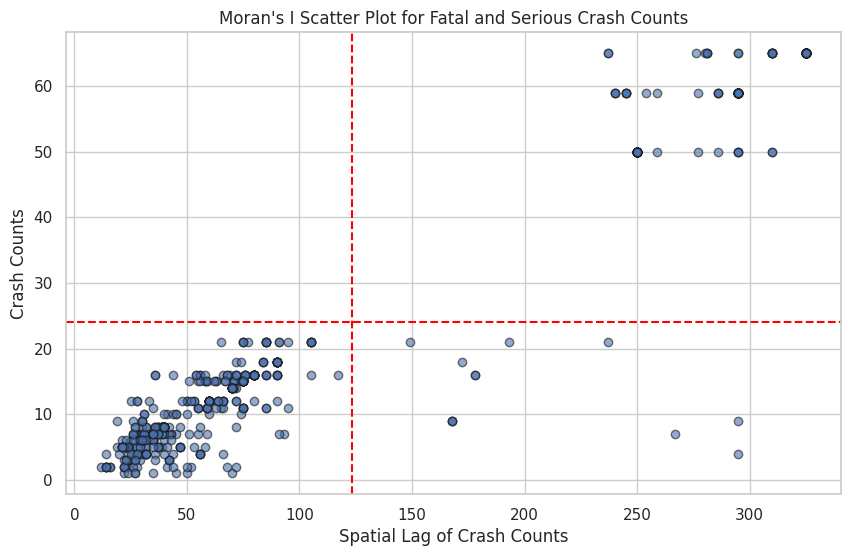

In [97]:
import geopandas as gpd
import libpysal
from esda import Moran
import matplotlib.pyplot as plt

# Load your data (assuming it's already a GeoDataFrame)
# traffic_data = gpd.read_file('your_data_file.geojson')  # Example

# Filter the data for Fatal and Serious Crashes
fatal_serious_data = traffic_data[(traffic_data['crashSeverity'] == 'Fatal Crash') | 
                                   (traffic_data['crashSeverity'] == 'Serious Crash')]

# Group by area unit and count the Fatal and Serious crashes
crash_counts_fatal_serious = (fatal_serious_data
                               .groupby('areaUnitID')  # Adjust as necessary
                               .size()
                               .reset_index(name='crash_count'))  # Create a DataFrame with counts

# Merge crash counts back to the original GeoDataFrame to retain geometry
crash_counts_geo_fatal_serious = fatal_serious_data[['areaUnitID', 'geometry']].drop_duplicates()
crash_counts_geo_fatal_serious = crash_counts_geo_fatal_serious.merge(crash_counts_fatal_serious, on='areaUnitID', how='left')

# Clean your data: drop rows with NaN values in the crash count column
crash_counts_geo_fatal_serious = crash_counts_geo_fatal_serious.dropna(subset=['crash_count'])

# Create a spatial weights matrix (e.g., k-nearest neighbors)
w_fatal_serious = libpysal.weights.KNN.from_dataframe(crash_counts_geo_fatal_serious, k=5)

# Calculate the spatial lag of crash counts
lag_crash_counts = libpysal.weights.lag_spatial(w_fatal_serious, crash_counts_geo_fatal_serious['crash_count'])

# Calculate Moran's I
moran_crash_fatal_serious = Moran(crash_counts_geo_fatal_serious['crash_count'], w_fatal_serious)

# Output results
print("Moran's I for fatal and serious Crash Counts:", moran_crash_fatal_serious.I)
print("p-value:", moran_crash_fatal_serious.p_sim)

# Create Moran's I scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(lag_crash_counts, crash_counts_geo_fatal_serious['crash_count'],
            alpha=0.6, edgecolor='k')
plt.xlabel('Spatial Lag of Crash Counts')
plt.ylabel('Crash Counts')
plt.title("Moran's I Scatter Plot for Fatal and Serious Crash Counts")
plt.axhline(y=crash_counts_geo_fatal_serious['crash_count'].mean(), color='red', linestyle='--')
plt.axvline(x=lag_crash_counts.mean(), color='red', linestyle='--')
plt.grid(True)
plt.show()


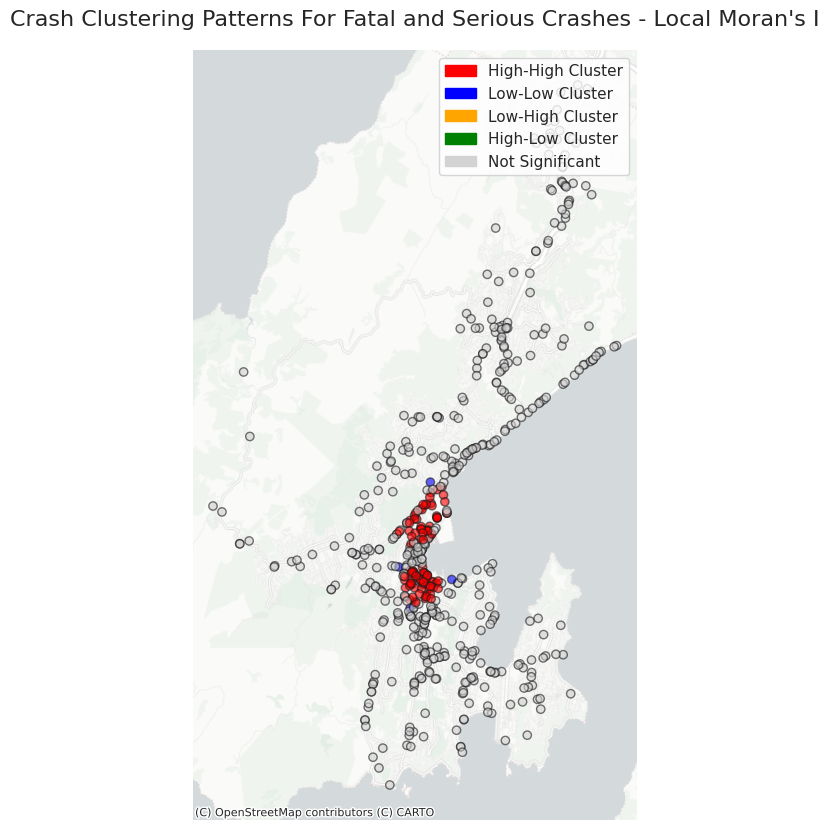

In [104]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from esda import Moran_Local
from libpysal import weights
import contextily as ctx

# Filter the data for Fatal and Serious Crashes
fatal_serious_data = traffic_data[(traffic_data['crashSeverity'] == 'Fatal Crash') | 
                                   (traffic_data['crashSeverity'] == 'Serious Crash')]

# Group by area unit and count the Fatal and Serious crashes
crash_counts_fatal_serious = (fatal_serious_data
                               .groupby('areaUnitID')  # Adjust as necessary
                               .size()
                               .reset_index(name='crash_count'))  # Create a DataFrame with counts

# Merge crash counts back to the original GeoDataFrame to retain geometry
crash_counts_geo_fatal_serious = fatal_serious_data[['areaUnitID', 'geometry']].drop_duplicates()
crash_counts_geo_fatal_serious = crash_counts_geo_fatal_serious.merge(crash_counts_fatal_serious, on='areaUnitID', how='left')

# Clean your data: drop rows with NaN values in the crash count column
crash_counts_geo_fatal_serious = crash_counts_geo_fatal_serious.dropna(subset=['crash_count'])

# Ensure the crash_counts_geo_fatal_serious data is in EPSG:3857
crash_counts_geo_fatal_serious = crash_counts_geo_fatal_serious.to_crs(epsg=3857)

# Create a spatial weights matrix
w_fatal_serious = weights.Queen.from_dataframe(crash_counts_geo_fatal_serious, use_index=True)

# Calculate Local Moran's I using the Moran_Local class
moran_local_fatal_serious = Moran_Local(crash_counts_geo_fatal_serious['crash_count'], w_fatal_serious)

# Add Local Moran's I results to the GeoDataFrame
crash_counts_geo_fatal_serious['local_moran'] = moran_local_fatal_serious.Is  # Local Moran's I values
crash_counts_geo_fatal_serious['significance'] = moran_local_fatal_serious.p_sim  # p-value for significance
crash_counts_geo_fatal_serious['z_sim'] = moran_local_fatal_serious.z_sim  # Standardized statistic

# Define custom thresholds based on percentiles for more balanced clusters
high_threshold_moran_fatal_serious = crash_counts_geo_fatal_serious['local_moran'].quantile(0.75)  # 75th percentile
low_threshold_moran_fatal_serious = crash_counts_geo_fatal_serious['local_moran'].quantile(0.25)   # 25th percentile

high_threshold_z_fatal_serious = crash_counts_geo_fatal_serious['z_sim'].quantile(0.75)  # 75th percentile
low_threshold_z_fatal_serious = crash_counts_geo_fatal_serious['z_sim'].quantile(0.25)   # 25th percentile

# Use a higher significance threshold to capture more clusters
significance_threshold_fatal_serious = 0.05

# Define conditions for each cluster type
conditions_fatal_serious = [
    (crash_counts_geo_fatal_serious['significance'] < significance_threshold_fatal_serious) & 
    (crash_counts_geo_fatal_serious['local_moran'] > high_threshold_moran_fatal_serious) & 
    (crash_counts_geo_fatal_serious['z_sim'] > high_threshold_z_fatal_serious),  # high-high
    
    (crash_counts_geo_fatal_serious['significance'] < significance_threshold_fatal_serious) & 
    (crash_counts_geo_fatal_serious['local_moran'] < low_threshold_moran_fatal_serious) & 
    (crash_counts_geo_fatal_serious['z_sim'] < low_threshold_z_fatal_serious),  # low-low
    
    (crash_counts_geo_fatal_serious['significance'] < significance_threshold_fatal_serious) & 
    (crash_counts_geo_fatal_serious['local_moran'] < low_threshold_moran_fatal_serious) & 
    (crash_counts_geo_fatal_serious['z_sim'] > high_threshold_z_fatal_serious),  # low-high
    
    (crash_counts_geo_fatal_serious['significance'] < significance_threshold_fatal_serious) & 
    (crash_counts_geo_fatal_serious['local_moran'] > high_threshold_moran_fatal_serious) & 
    (crash_counts_geo_fatal_serious['z_sim'] < low_threshold_z_fatal_serious)   # high-low
]

# Define labels for clusters
cluster_labels_fatal_serious = ['high-high', 'low-low', 'low-high', 'high-low']

# Apply conditions to assign cluster types
crash_counts_geo_fatal_serious['cluster_type'] = np.select(conditions_fatal_serious, cluster_labels_fatal_serious, default='Not Significant')

# Define colors for each cluster type
color_mapping_fatal_serious = {
    'high-high': 'red',
    'low-low': 'blue',
    'low-high': 'orange',
    'high-low': 'green',
    'Not Significant': 'lightgrey'
}

# Apply color mapping
crash_counts_geo_fatal_serious['color'] = crash_counts_geo_fatal_serious['cluster_type'].map(color_mapping_fatal_serious)

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with colors
crash_counts_geo_fatal_serious.plot(ax=ax, color=crash_counts_geo_fatal_serious['color'], alpha=0.6, edgecolor='k')  # Added edgecolor for visibility

# Add the basemap
ctx.add_basemap(
    ax,  # Pass the axis to the basemap
    crs=crash_counts_geo_fatal_serious.crs.to_string(),  # Use the crash_counts_geo_fatal_serious data's CRS
    source=ctx.providers.CartoDB.PositronNoLabels
)

# Remove axes for better visualization
ax.set_axis_off()

# Add a title
plt.title("Crash Clustering Patterns For Fatal and Serious Crashes - Local Moran's I", fontsize=16)

# Create a custom legend
import matplotlib.patches as mpatches

legend_elements_fatal_serious = [
    mpatches.Patch(color='red', label='High-High Cluster'),
    mpatches.Patch(color='blue', label='Low-Low Cluster'),
    mpatches.Patch(color='orange', label='Low-High Cluster'),
    mpatches.Patch(color='green', label='High-Low Cluster'),
    mpatches.Patch(color='lightgrey', label='Not Significant')
]

ax.legend(handles=legend_elements_fatal_serious, loc='upper right')

# Show the plot
plt.show()


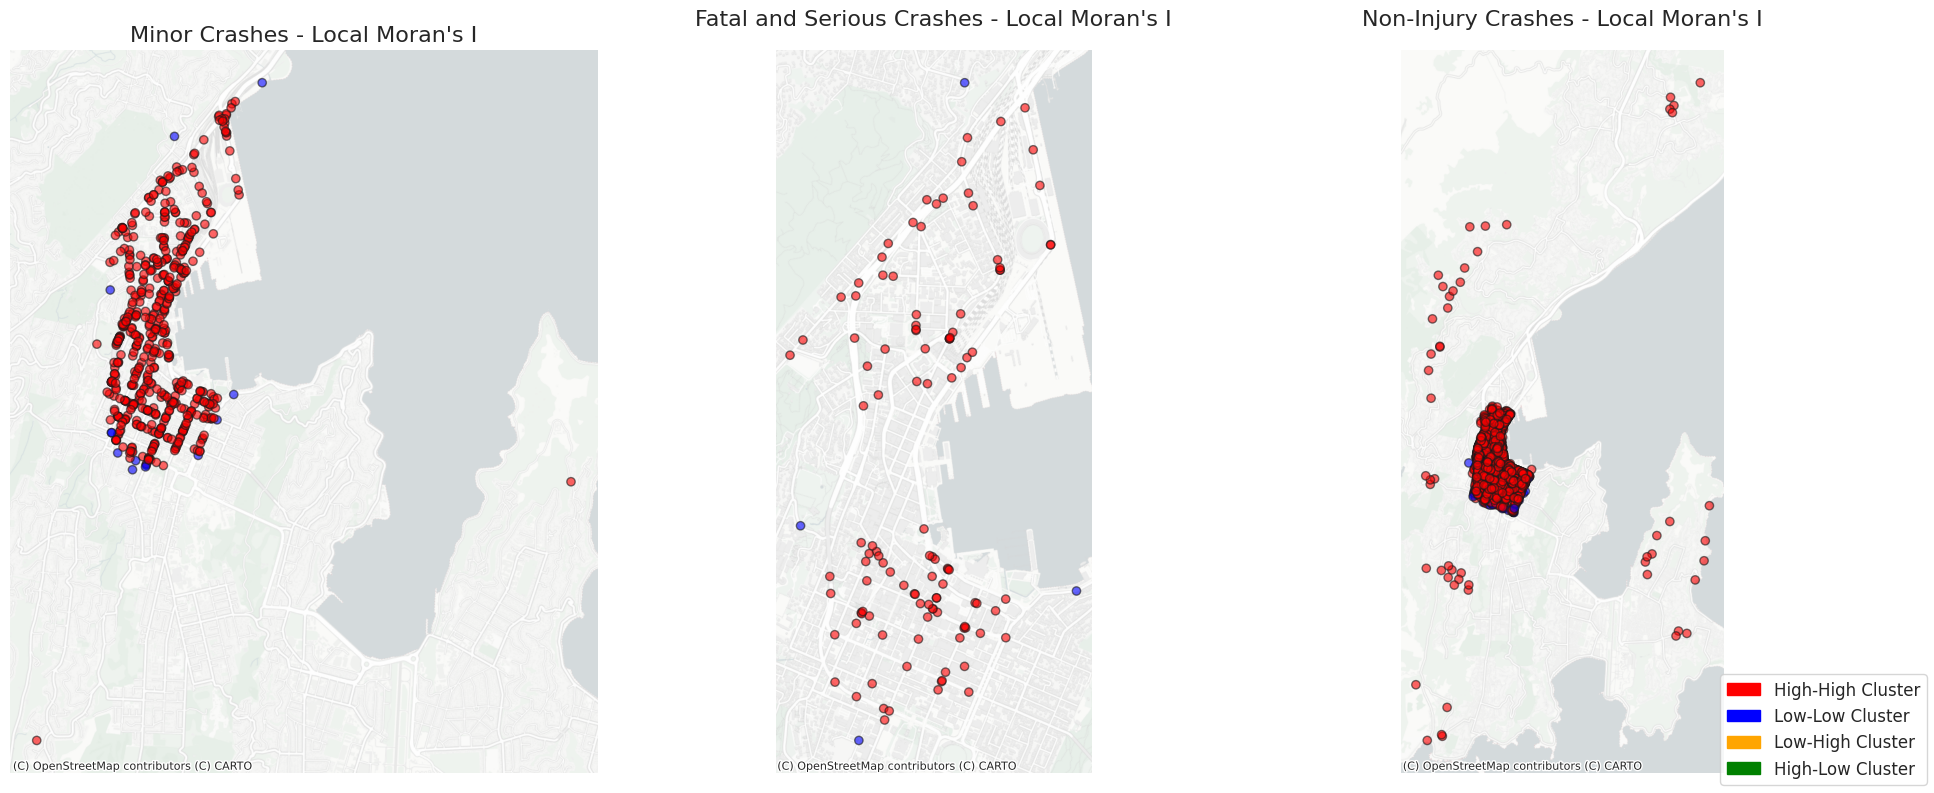

In [99]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from esda import Moran_Local
from libpysal import weights
import contextily as ctx

# Assuming crash_counts_geo_minor, crash_counts_geo_fatal_serious, and crash_counts_geo_non_injury are already prepared

# Function to perform Local Moran's I analysis and plot
def analyze_and_plot(crash_counts_geo, title, ax):
    # Create a spatial weights matrix
    w = weights.Queen.from_dataframe(crash_counts_geo, use_index=True)
    
    # Calculate Local Moran's I
    moran_local = Moran_Local(crash_counts_geo['crash_count'], w)
    
    # Add Local Moran's I results to the GeoDataFrame
    crash_counts_geo['local_moran'] = moran_local.Is
    crash_counts_geo['significance'] = moran_local.p_sim
    crash_counts_geo['z_sim'] = moran_local.z_sim
    
    # Define custom thresholds based on percentiles
    high_threshold_moran = crash_counts_geo['local_moran'].quantile(0.75)
    low_threshold_moran = crash_counts_geo['local_moran'].quantile(0.25)
    high_threshold_z = crash_counts_geo['z_sim'].quantile(0.75)
    low_threshold_z = crash_counts_geo['z_sim'].quantile(0.25)

    # Define significance threshold
    significance_threshold = 0.05

    # Define conditions for clustering
    conditions = [
        (crash_counts_geo['significance'] < significance_threshold) & 
        (crash_counts_geo['local_moran'] > high_threshold_moran) & 
        (crash_counts_geo['z_sim'] > high_threshold_z),  # high-high
        (crash_counts_geo['significance'] < significance_threshold) & 
        (crash_counts_geo['local_moran'] < low_threshold_moran) & 
        (crash_counts_geo['z_sim'] < low_threshold_z),  # low-low
        (crash_counts_geo['significance'] < significance_threshold) & 
        (crash_counts_geo['local_moran'] < low_threshold_moran) & 
        (crash_counts_geo['z_sim'] > high_threshold_z),  # low-high
        (crash_counts_geo['significance'] < significance_threshold) & 
        (crash_counts_geo['local_moran'] > high_threshold_moran) & 
        (crash_counts_geo['z_sim'] < low_threshold_z)   # high-low
    ]

    # Assign cluster types
    cluster_labels = ['high-high', 'low-low', 'low-high', 'high-low']
    crash_counts_geo['cluster_type'] = np.select(conditions, cluster_labels, default='Not Significant')

    # Define colors for each cluster type
    color_mapping = {
        'high-high': 'red',
        'low-low': 'blue',
        'low-high': 'orange',
        'high-low': 'green',
        'Not Significant': 'lightgrey'
    }

    # Apply color mapping
    crash_counts_geo['color'] = crash_counts_geo['cluster_type'].map(color_mapping)

    # Filter out "Not Significant" points for plotting
    gdf = crash_counts_geo[crash_counts_geo['cluster_type'] != 'Not Significant']
    
    # Plot the GeoDataFrame with colors
    gdf.plot(ax=ax, color=gdf['color'], alpha=0.6, edgecolor='k')
    
    # Add the basemap
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
    
    # Remove axes for better visualization
    ax.set_axis_off()
    
    # Set the title
    ax.set_title(title, fontsize=16)

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Perform analysis and plotting for each crash type
analyze_and_plot(crash_counts_geo_minor, "Minor Crashes - Local Moran's I", axs[0])
analyze_and_plot(crash_counts_geo_fatal_serious, "Fatal and Serious Crashes - Local Moran's I", axs[1])
analyze_and_plot(crash_counts_geo_non_injury, "Non-Injury Crashes - Local Moran's I", axs[2])

# Create a custom legend
import matplotlib.patches as mpatches

legend_elements = [
    mpatches.Patch(color='red', label='High-High Cluster'),
    mpatches.Patch(color='blue', label='Low-Low Cluster'),
    mpatches.Patch(color='orange', label='Low-High Cluster'),
    mpatches.Patch(color='green', label='High-Low Cluster'),
]

# Add legend to the figure
fig.legend(handles=legend_elements, loc='lower right', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()
